In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [78]:
client = bnb_client(tld='US')

def get_data(symbol,freq,start_ts = '2025-01-01',end_ts='2025-07-15'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data

In [93]:
universe = ['ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT', 'XRPUSDT',  'DOGEUSDT']

# , 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT', 'XRPUSDT',  'DOGEUSDT'
freq = '1d'


px = {}
for x in universe:
    data = get_data(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_9102/67391828.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_9102/67391828.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_9102/67391828.py:12: Depre

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT,XRPUSDT,DOGEUSDT
2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 12:00:00,0.031256,0.016128,0.010023,0.048644,0.031234,0.013696,0.021908
2024-01-02 00:00:00,0.031955,0.021675,0.020807,0.042629,0.007411,0.002861,0.009468
2024-01-02 12:00:00,-0.009961,-0.014686,-0.022891,-0.059791,-0.032145,-0.010144,-0.018650
2024-01-03 00:00:00,-0.021880,-0.020899,0.039474,-0.023473,-0.010410,-0.011369,-0.016258
...,...,...,...,...,...,...,...
2025-07-13 00:00:00,0.005243,0.007502,0.008797,0.007843,0.024824,0.015916,0.003945
2025-07-13 12:00:00,0.009235,0.003662,0.001304,-0.003088,0.016378,0.019655,-0.001663
2025-07-14 00:00:00,0.019937,0.027057,0.018402,0.032338,0.014624,0.050322,0.038658
2025-07-14 12:00:00,-0.013126,-0.013452,-0.022559,-0.025864,-0.019485,-0.006308,-0.042175


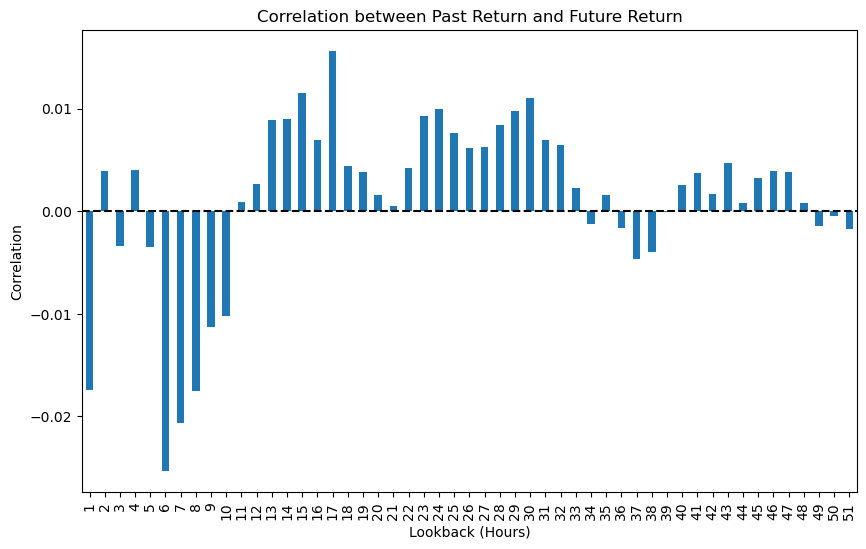

In [44]:
momentum = {}

periods = range(1,52)

for p in periods:
    
    window = ret.rolling(p).mean()
    nextReturn = ret.shift(-1)
    
    # Find valid periods where a nextReturn is found
    valid = window.stack().dropna().index.intersection(nextReturn.stack().dropna().index)
    
    window = window.stack().loc[valid]
    nextReturn = nextReturn.stack().loc[valid]
    
    # Calculate correlation between window and the next 4 hours
    corr = window.corr(nextReturn)
    momentum[p] = corr 
    
pd.Series(momentum).plot.bar(title="Correlation between Past Return and Future Return", ylabel="Correlation", xlabel="Lookback (Hours)", figsize=(10,6))
plt.axhline(0, color='black', linestyle='--')
plt.show()

/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_9102/1020741192.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)


1                                                 
             ETHUSDT   BNBUSDT   SOLUSDT   ADAUSDT  XRPUSDT  DOGEUSDT
2025-12-31  2.747747  1.237487  2.828037  2.788862  3.22451  1.527388

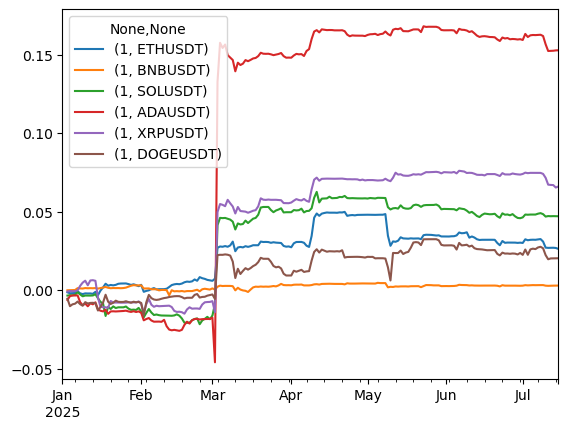

In [96]:
strat_returns = {}
lookbacks = range(1,2) 

for x in lookbacks:
    for y in universe:
        # Looking at momentum reversal 12-24 hours after
        weights = ret[y].rolling(x).mean() * -1
        weighted_returns = weights.shift() * ret[y]
        strat_returns[(x, y)] = weighted_returns

strat_returns = pd.DataFrame(strat_returns)
sharpe = strat_returns.mean()/strat_returns.std()*np.sqrt(365*24/4)
sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)
strat_returns.cumsum().plot()
sr

/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_9102/1704984905.py:15: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)


,5,6
2024-12-31,-0.183738,0.987848
2025-12-31,2.625334,2.832518


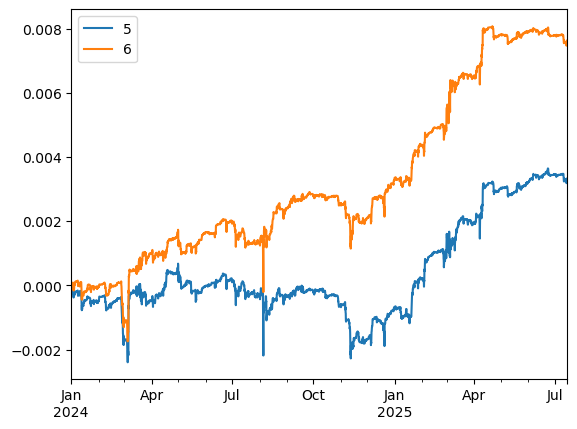

In [53]:
# Solo Coin 


strat_returns = {}
lookbacks = range(5,7) 


for x in lookbacks:
    weights = ret.rolling(x).mean() * -1
    strat_returns[x] = (weights.shift() * ret).sum(1)
    

strat_returns = pd.DataFrame(strat_returns)
sharpe = strat_returns.mean()/strat_returns.std()*np.sqrt(365*24/4)
sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)
strat_returns.cumsum().plot()
sr

np.float64(1.6971834393826153)

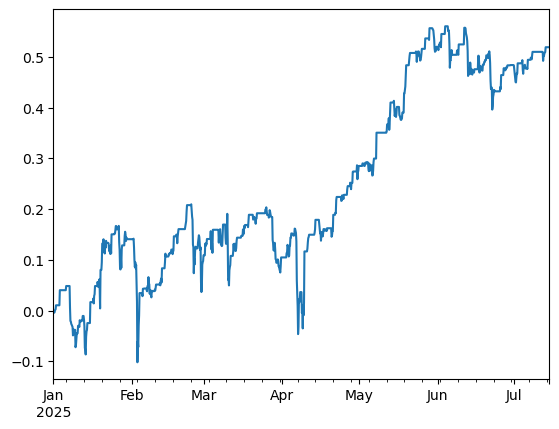

In [89]:
x = 6


# ret['window'] = ret.rolling(x).mean()
ret['position'] = ((ret['window'] > 0) * -1) + 1
ret['strat_return'] = ret['position'].shift() * ret['ETHUSDT']

sr = ret['strat_return'].mean() / ret['strat_return'].std() * np.sqrt(6*356)

ret['strat_return'].cumsum().plot()

sr